# DigitRecognizer for a ML challenge
+ The goal of this notebook is to explore the data provided and to have a first base model

+ URL of the challenge: https://www.kaggle.com/competitions/digit-recognizer

+ Pipeline:
    + 1-Exploring the data
    + 2-Visualizing values
    + 3-Fixing validation dataset to iterate
    + 4-Training a model, see results and make error analysing
    + 5-Making a change and iterate again
    + 6-Repeating 4 and 5 as desired

**Content:**
1. [Loading libraries](#1)
1. [Visualizing data](#2)
1. [Creating a CSV](#3)
1. [Fastai and tabular data](#4)
    1. [accuracy=0.969, No augmentations, bs=64, Basic NN [200,100], fit_one_cycle(10, 1e-3)](#5)
    1. [accuracy=0.966, No augmentations, bs=64, BasicNN[200,100], fit_one_cycle(10, 1e-3),wd=0.1](#6)
    1. [accuracy=0.970, No augmentations, bs=64, BasicNN[400,250,100], fit_one_cycle(10, 1e-3, wd=0.1)](#7)
    1. [accuracy=0.964, RandomForest(n_estimators=100, random_state=2021, oob_score=True)](#8)
    1. [accuracy=0.962, GridSearch, RandomForest(bootstrap= True,max_depth= 200,max_features= 12,min_samples_leaf= 1,min_samples_split= 2,n_estimators= 100)](#9)

<a id="1"></a> <br>
# Loading libraries
+ We use fastai, numpy, sklearn and matplotlib


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import fastai
import torch
from sklearn.metrics import confusion_matrix, classification_report
from fastai.tabular.all import *

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
print("Fastai version: ",fastai.__version__)

Fastai version:  2.6.0


In [5]:
print("GPU to use: ",torch.cuda.get_device_name(0))

GPU to use:  Tesla P100-PCIE-16GB


In [6]:
#To show and save the graphics in the notebook
%matplotlib inline
#To reload automatically all the modules after executing a cell
%reload_ext autoreload
%autoreload 2

<a id="2"></a> <br>
# Visualizing data
+ Let's take a look to the data provided

In [7]:
root_path='/kaggle/input/digit-recognizer/'
df_train=pd.read_csv(os.path.join(root_path, 'train.csv'))

In [8]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

<AxesSubplot:>

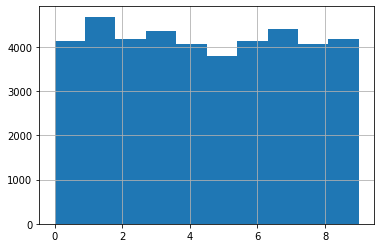

In [10]:
df_train.label.hist()

+ We see the 784 columns corresponding to the pixels values (between 0 and 255) and the label column for each of the 42000 rows in the training set
+ The label column is quite balanced so that is good news

Label: 7


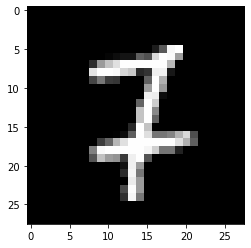

In [11]:
sample_index=df_train.sample(1).index[0]
image=np.array(df_train.iloc[sample_index,df_train.columns!='label']).reshape(28,28)
plt.imshow(image,cmap='gray')
print(f'Label: {df_train.iloc[sample_index].label}')

<a id="3"></a> <br>
# Creating a CSV
+ Let's create a fixed CSV with train and val to be able to compare models with the same validation set

In [12]:
df_val=df_train.sample(int(np.round(len(df_train)*0.25)))
df_val['set']='val'

+ We select 25% of the original train set randomly for the validation set
+ As the original train set is balanced, we are quite sure that the val set will contain all the different labels

In [13]:
df_train=df_train[~df_train.index.isin(df_val.index)]
df_train['set']='train'

In [14]:
df=pd.concat([df_train,df_val])
df=df.reset_index()
df=df.drop(['index'],axis=1)
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,set
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,val
41996,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,val
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,val
41998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,val


In [ ]:
df.to_csv('./MNIST_tabular_dataset.csv',index=False)

<a id="4"></a> <br>
# Fastai and tabular data 
+ As the data provided is tabular data, our first approach is to create a tabular model to be able to predict the correct labels
+ We use fastai for this purpose

<a id="5"></a> <br>
## accuracy=0.969, bs=64, Basic NN [200,100], fit_one_cycle(10, 1e-3)

In [15]:
path=Path('../input/digit-recognizer')

In [16]:
df=pd.read_csv('../input/mnist-tabular-dataset/MNIST_tabular_dataset.csv')

In [17]:
dls = TabularDataLoaders.from_df(df,
                                path='.',
                                y_names="label",  
                                cont_names=df.drop(['set', 'label'], axis=1).columns.tolist(), 
                                y_block = CategoryBlock(),
                                valid_idx=df[df.set=='val'].index.tolist(),
                                bs=64)

In [18]:
dls.show_batch()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [19]:
learn = tabular_learner(dls, metrics=accuracy)

In [20]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=784, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=10, bias=True)
    )
  )
)

+ tabular_learner() is a normal Deep NN.
+ The arch starts with embedding the categorical values.
+ Then a Sequential Block is composed of two layers (Linear --> ReLu -->BatchNorm).
+ A final output linear layer is attached at the end

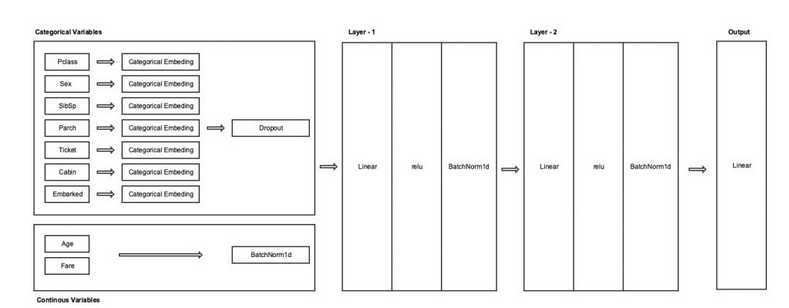

SuggestedLRs(valley=0.0014454397605732083)

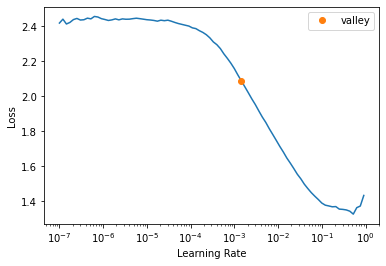

In [21]:
learn.lr_find()

+ We find the optimal lr

In [22]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.303829,5.767959,0.927143,00:06
1,0.164025,7.040240,0.951905,00:06
2,0.113670,6.031390,0.957810,00:07
3,0.081550,16.909187,0.957714,00:06
4,0.055440,11.915519,0.964952,00:06
5,0.027650,18.485970,0.962000,00:06
6,0.017078,17.964943,0.966000,00:06
7,0.010662,15.694755,0.967905,00:06
8,0.006769,19.459173,0.970571,00:06
9,0.007148,12.928700,0.969429,00:06


+ We iterate just a few epochs to find some hyperparameters

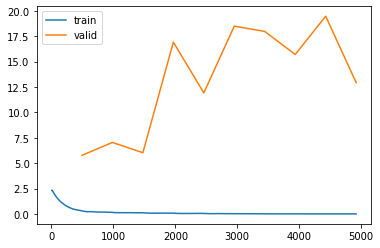

In [23]:
learn.recorder.plot_loss()

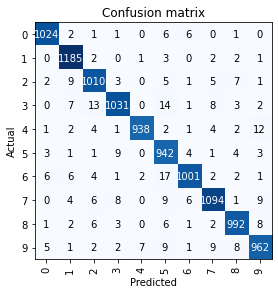

In [24]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

In [25]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1041
           1       0.97      0.99      0.98      1196
           2       0.96      0.97      0.97      1043
           3       0.97      0.96      0.96      1079
           4       0.99      0.97      0.98       967
           5       0.93      0.97      0.95       968
           6       0.98      0.96      0.97      1042
           7       0.97      0.96      0.97      1137
           8       0.97      0.97      0.97      1021
           9       0.96      0.96      0.96      1006

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



+ We can see that the model is overfitting to early

In [26]:
preds, test_labels = learn.get_preds()

In [27]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [28]:
def return_index_of_errors(test_labels,final_preds):
    return np.where(np.not_equal(final_preds,np.array(test_labels).reshape(len(np.array(test_labels)))))[0]

In [29]:
indexes_to_check=return_index_of_errors(test_labels,final_preds)

In [30]:
df_val=learn.dls.valid.items
df_val=df_val.reset_index()
df_val=df_val.drop(['index'],axis=1)

Label: 7
Prediction: 5


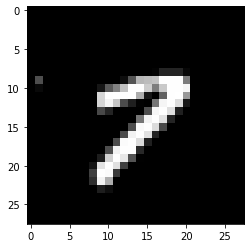

In [31]:
sample_index=df_val.iloc[np.random.choice(indexes_to_check)].name
image=np.array(df_val.iloc[sample_index,(df_val.columns!='label')&((df_val.columns!='set'))],dtype='uint8').reshape(28,28)
plt.imshow(image,cmap='gray')
print(f'Label: {df_val.iloc[sample_index].label}')
print(f'Prediction: {final_preds[sample_index]}')

+ Let's try out some regularization

<a id="6"></a> <br>
## accuracy=0.966, bs=64, BasicNN[200,100], fit_one_cycle(10, 1e-3, wd=0.1)

In [32]:
path=Path('../input/digit-recognizer')

In [33]:
df=pd.read_csv('../input/mnist-tabular-dataset/MNIST_tabular_dataset.csv')

In [34]:
dls = TabularDataLoaders.from_df(df,
                                path='.',
                                y_names="label",  
                                cont_names=df.drop(['set', 'label'], axis=1).columns.tolist(), 
                                y_block = CategoryBlock(),
                                valid_idx=df[df.set=='val'].index.tolist(),
                                bs=64)

In [35]:
dls.show_batch()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [36]:
learn = tabular_learner(dls, metrics=accuracy,layers=[200,100])

SuggestedLRs(valley=0.0010000000474974513)

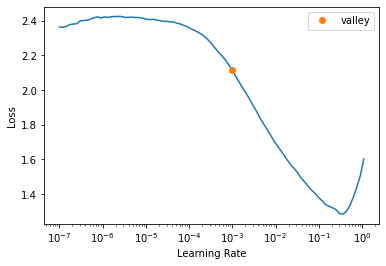

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(10, 1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.306070,4.511577,0.927810,00:06
1,0.158432,5.399704,0.948476,00:06
2,0.118738,7.232300,0.950952,00:07
3,0.079861,14.178384,0.961810,00:06
4,0.064141,16.469547,0.960952,00:07
5,0.036258,12.651933,0.965333,00:06
6,0.019554,25.653473,0.965714,00:06
7,0.014390,11.120022,0.967238,00:07
8,0.007414,28.442589,0.967809,00:06
9,0.005808,14.371498,0.966571,00:06


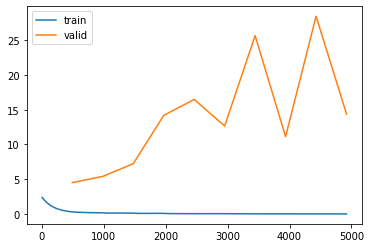

In [39]:
learn.recorder.plot_loss()

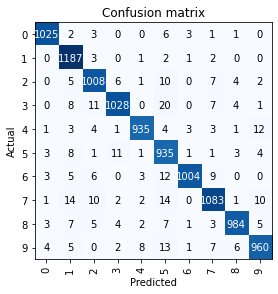

In [40]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

In [41]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1041
           1       0.95      0.99      0.97      1196
           2       0.96      0.97      0.96      1043
           3       0.98      0.95      0.96      1079
           4       0.98      0.97      0.97       967
           5       0.91      0.97      0.94       968
           6       0.99      0.96      0.98      1042
           7       0.96      0.95      0.96      1137
           8       0.98      0.96      0.97      1021
           9       0.97      0.95      0.96      1006

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



In [42]:
preds, test_labels = learn.get_preds()

In [43]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [44]:
def return_index_of_errors(test_labels,final_preds):
    return np.where(np.not_equal(final_preds,np.array(test_labels).reshape(len(np.array(test_labels)))))[0]

In [45]:
indexes_to_check=return_index_of_errors(test_labels,final_preds)

In [46]:
df_val=learn.dls.valid.items
df_val=df_val.reset_index()
df_val=df_val.drop(['index'],axis=1)

Label: 9
Prediction: 4


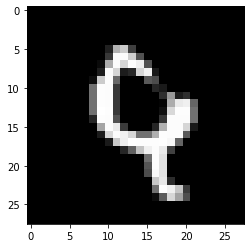

In [47]:
sample_index=df_val.iloc[np.random.choice(indexes_to_check)].name
image=np.array(df_val.iloc[sample_index,(df_val.columns!='label')&((df_val.columns!='set'))],dtype='uint8').reshape(28,28)
plt.imshow(image,cmap='gray')
print(f'Label: {df_val.iloc[sample_index].label}')
print(f'Prediction: {final_preds[sample_index]}')

+ Little improvement. Let's try a bigger model

<a id="7"></a> <br>
## accuracy=0.970, bs=64, BasicNN[400,250,100], fit_one_cycle(10, 1e-3,wd=0.1)

In [48]:
path=Path('../input/digit-recognizer')

In [49]:
df=pd.read_csv('../input/mnist-tabular-dataset/MNIST_tabular_dataset.csv')

In [50]:
dls = TabularDataLoaders.from_df(df,
                                path='.',
                                y_names="label",  
                                cont_names=df.drop(['set', 'label'], axis=1).columns.tolist(), 
                                y_block = CategoryBlock(),
                                valid_idx=df[df.set=='val'].index.tolist(),
                                bs=64)

In [51]:
dls.show_batch()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [52]:
learn = tabular_learner(dls, metrics=accuracy,layers=[400,250,100])

SuggestedLRs(valley=0.0005754399462603033)

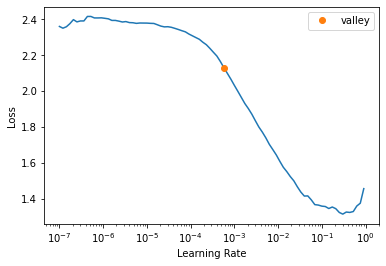

In [53]:
learn.lr_find()

In [54]:
learn.fit_one_cycle(10, 1e-3,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.258180,3.163415,0.938952,00:07
1,0.174428,3.312381,0.941238,00:06
2,0.132198,5.806134,0.956476,00:07
3,0.093611,5.652936,0.962095,00:07
4,0.060944,8.128454,0.962381,00:06
5,0.039433,8.300724,0.968857,00:07
6,0.019046,8.001189,0.965143,00:06
7,0.009651,8.429895,0.970952,00:07
8,0.004079,5.004992,0.970190,00:07
9,0.003011,4.478591,0.970000,00:06


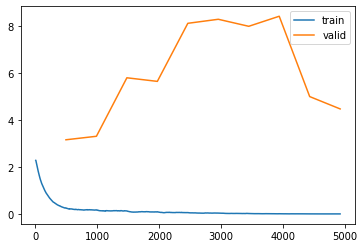

In [55]:
learn.recorder.plot_loss()

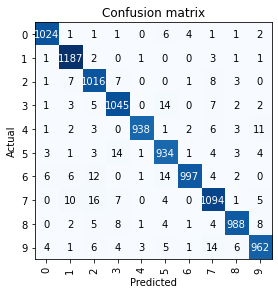

In [56]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

In [57]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1041
           1       0.97      0.99      0.98      1196
           2       0.95      0.97      0.96      1043
           3       0.96      0.97      0.97      1079
           4       0.99      0.97      0.98       967
           5       0.95      0.96      0.96       968
           6       0.99      0.96      0.97      1042
           7       0.96      0.96      0.96      1137
           8       0.98      0.97      0.97      1021
           9       0.97      0.96      0.96      1006

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



In [58]:
preds, test_labels = learn.get_preds()

In [59]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [60]:
def return_index_of_errors(test_labels,final_preds):
    return np.where(np.not_equal(final_preds,np.array(test_labels).reshape(len(np.array(test_labels)))))[0]

In [61]:
indexes_to_check=return_index_of_errors(test_labels,final_preds)

In [66]:
print(f'Number of errors on validation set: {len(indexes_to_check)} out of {len(test_labels)}')

Number of errors on validation set: 315 out of 10500


In [62]:
df_val=learn.dls.valid.items
df_val=df_val.reset_index()
df_val=df_val.drop(['index'],axis=1)

Label: 8
Prediction: 5


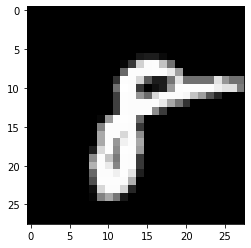

In [63]:
sample_index=df_val.iloc[np.random.choice(indexes_to_check)].name
image=np.array(df_val.iloc[sample_index,(df_val.columns!='label')&((df_val.columns!='set'))],dtype='uint8').reshape(28,28)
plt.imshow(image,cmap='gray')
print(f'Label: {df_val.iloc[sample_index].label}')
print(f'Prediction: {final_preds[sample_index]}')

In [ ]:
learn.export('./NN_acc0970.pkl')

+ Let's try out Classical Ensembles to try to improve that

<a id="8"></a> <br>
## accuracy=0.964, RandomForest(n_estimators=100, random_state=2021, oob_score=True)

In [67]:
df=pd.read_csv('../input/mnist-tabular-dataset/MNIST_tabular_dataset.csv')

In [68]:
X_train=df.iloc[:,(df.columns!='label')&((df.columns!='set'))][df.set=='train']
y_train=df.iloc[:,df.columns=='label'][df.set=='train']
X_val=df.iloc[:,(df.columns!='label')&((df.columns!='set'))][df.set=='val']
y_val=df.iloc[:,df.columns=='label'][df.set=='val']

+ Let's try out some default hyperparameters

In [69]:
m = RandomForestClassifier(n_estimators=100, random_state=2021, oob_score=True)#, min_samples_leaf = 100)
m = m.fit(X_train, y_train.squeeze())

In [70]:
pred_train = m.predict(X_train)
pred_val = m.predict(X_val)

In [71]:
def get_accuracy(y_true,y_pred):
    return accuracy_score(y_true,y_pred)

In [72]:
def report_metrics(y_true, y_pred):
    print(f'Accuracy: {get_accuracy(y_true,y_pred)}')
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [73]:
report_metrics(np.array(y_train.squeeze()),pred_train)

Accuracy: 1.0
[[3091    0    0    0    0    0    0    0    0    0]
 [   0 3488    0    0    0    0    0    0    0    0]
 [   0    0 3134    0    0    0    0    0    0    0]
 [   0    0    0 3272    0    0    0    0    0    0]
 [   0    0    0    0 3105    0    0    0    0    0]
 [   0    0    0    0    0 2827    0    0    0    0]
 [   0    0    0    0    0    0 3095    0    0    0]
 [   0    0    0    0    0    0    0 3264    0    0]
 [   0    0    0    0    0    0    0    0 3042    0]
 [   0    0    0    0    0    0    0    0    0 3182]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3091
           1       1.00      1.00      1.00      3488
           2       1.00      1.00      1.00      3134
           3       1.00      1.00      1.00      3272
           4       1.00      1.00      1.00      3105
           5       1.00      1.00      1.00      2827
           6       1.00      1.00      1.00      3095
           7       1.0

In [74]:
report_metrics(np.array(y_val.squeeze()),pred_val)

Accuracy: 0.9645714285714285
[[1025    0    1    0    0    0    8    0    6    1]
 [   0 1184    4    1    1    1    2    0    2    1]
 [   1    1 1009    5    4    0    1    9   13    0]
 [   1    0   17 1025    1   14    4    7    8    2]
 [   0    3    0    1  929    1    7    1    3   22]
 [   3    0    4   17    2  927    4    2    4    5]
 [   4    3    0    0    4    5 1022    0    4    0]
 [   2    4   19    1    5    0    0 1092    2   12]
 [   3    3    5   12    5    6    4    1  969   13]
 [  10    2    2   11   13    3    0   10    9  946]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1041
           1       0.99      0.99      0.99      1196
           2       0.95      0.97      0.96      1043
           3       0.96      0.95      0.95      1079
           4       0.96      0.96      0.96       967
           5       0.97      0.96      0.96       968
           6       0.97      0.98      0.98      1042
       

+ We got a little less accuracy than a normal NN
+ Let's find the best hyperparameters for the RandomForest

<a id="9"></a> <br>
## accuracy=0.963, GridSearch, RandomForest(bootstrap= True,max_depth= 200,max_features= 12,min_samples_leaf= 1,min_samples_split= 2,n_estimators= 100)

In [75]:
df=pd.read_csv('../input/mnist-tabular-dataset/MNIST_tabular_dataset.csv')

In [76]:
X_train=df.iloc[:,(df.columns!='label')&((df.columns!='set'))][df.set=='train']
y_train=df.iloc[:,df.columns=='label'][df.set=='train']
X_val=df.iloc[:,(df.columns!='label')&((df.columns!='set'))][df.set=='val']
y_val=df.iloc[:,df.columns=='label'][df.set=='val']

In [ ]:
# Grid for the best hyperparameters
#Comment for time consuming issue
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [50,75,100,150,200],
#    'max_features': [3,5,7, 10,12,15],
#    'min_samples_leaf': [1,10,20,30,40,50,60,70,80],
#    'min_samples_split': [1,2,3,4,5,10,20,30,40,50],
#    'n_estimators': [100]
#}

#rf = RandomForestClassifier()
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
#grid_search.fit(X_train, y_train.squeeze())

In [ ]:
#grid_search.best_params_

In [77]:
m = RandomForestClassifier(bootstrap= True,
 max_depth= 200,
 max_features= 12,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 100)

In [78]:
m = m.fit(X_train, y_train.squeeze())

In [79]:
pred_train = m.predict(X_train)
pred_val = m.predict(X_val)

In [80]:
def get_accuracy(y_true,y_pred):
    return accuracy_score(y_true,y_pred)

In [81]:
def report_metrics(y_true, y_pred):
    print(f'Accuracy: {get_accuracy(y_true,y_pred)}')
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [82]:
report_metrics(np.array(y_train.squeeze()),pred_train)

Accuracy: 1.0
[[3091    0    0    0    0    0    0    0    0    0]
 [   0 3488    0    0    0    0    0    0    0    0]
 [   0    0 3134    0    0    0    0    0    0    0]
 [   0    0    0 3272    0    0    0    0    0    0]
 [   0    0    0    0 3105    0    0    0    0    0]
 [   0    0    0    0    0 2827    0    0    0    0]
 [   0    0    0    0    0    0 3095    0    0    0]
 [   0    0    0    0    0    0    0 3264    0    0]
 [   0    0    0    0    0    0    0    0 3042    0]
 [   0    0    0    0    0    0    0    0    0 3182]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3091
           1       1.00      1.00      1.00      3488
           2       1.00      1.00      1.00      3134
           3       1.00      1.00      1.00      3272
           4       1.00      1.00      1.00      3105
           5       1.00      1.00      1.00      2827
           6       1.00      1.00      1.00      3095
           7       1.0

In [83]:
report_metrics(np.array(y_val.squeeze()),pred_val)

Accuracy: 0.962
[[1024    0    1    0    0    2    8    0    5    1]
 [   0 1180    6    1    2    2    2    0    1    2]
 [   0    2 1004    6    2    1    1   12   13    2]
 [   1    0   19 1021    1   11    3    7   14    2]
 [   1    2    4    0  925    1    6    1    5   22]
 [   5    0    2   15    3  930    6    0    2    5]
 [   4    4    0    0    4    6 1020    0    4    0]
 [   3    5   18    2    8    0    0 1084    2   15]
 [   3    4    5   11    2    9    4    1  968   14]
 [   8    2    1   15   14    1    0   11    9  945]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1041
           1       0.98      0.99      0.99      1196
           2       0.95      0.96      0.95      1043
           3       0.95      0.95      0.95      1079
           4       0.96      0.96      0.96       967
           5       0.97      0.96      0.96       968
           6       0.97      0.98      0.98      1042
           7       0

+ We see no improvements
+ Let's change our mind and focus on different approach: Images